In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# 1 - Load Dataset

In [3]:
df = pd.read_csv("uber.csv")
df = df.drop(["Unnamed: 0", "key"], axis=1)
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors='coerce')
df = df.dropna()

# 2 - Feature Engineering

In [4]:
def haversine_distance(lon1, lat1, lon2, lat2):
    distances = []
    for i in range(len(lon1)):
        lon1_rad, lat1_rad, lon2_rad, lat2_rad = map(radians, [lon1[i], lat1[i], lon2[i], lat2[i]])
        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad
        a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) * 6371  # Earth radius in km
        distances.append(c)
    return distances

df["distance_km"] = haversine_distance(df["pickup_longitude"].to_numpy(),
                                       df["pickup_latitude"].to_numpy(),
                                       df["dropoff_longitude"].to_numpy(),
                                       df["dropoff_latitude"].to_numpy())

# Extract date-time features
df["pickup_hr"] = df.pickup_datetime.dt.hour
df["day"] = df.pickup_datetime.dt.day
df["month"] = df.pickup_datetime.dt.month
df["year"] = df.pickup_datetime.dt.year
df["day_of_week"] = df.pickup_datetime.dt.dayofweek

# 3 - Outlier Removal

In [5]:
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] <= 100)]
df = df[(df["distance_km"] > 0) & (df["distance_km"] <= 60)]
df = df[df["passenger_count"] <= 6]

# 4 - Correlation Check

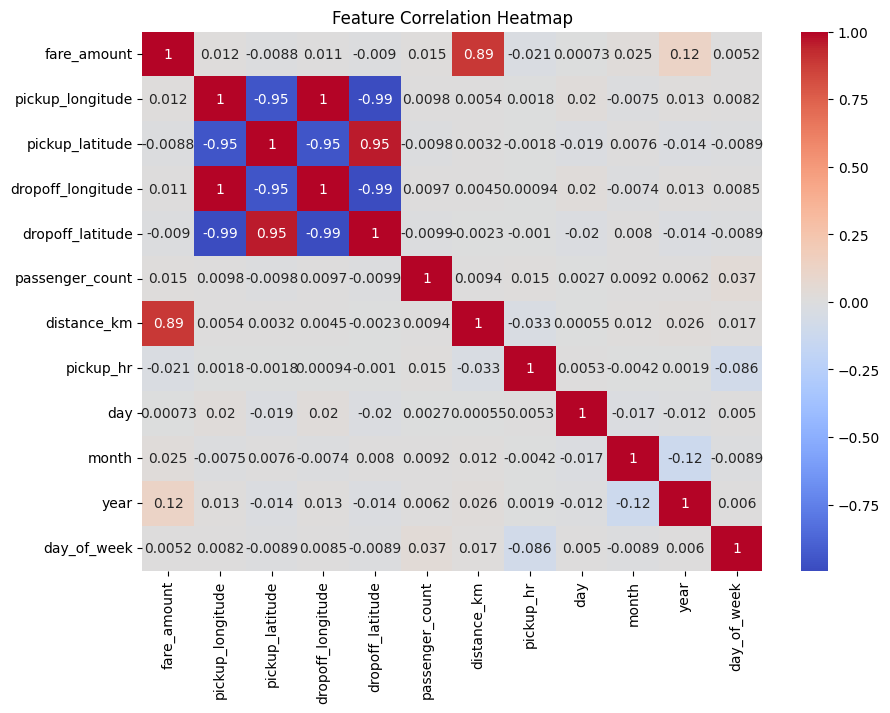

In [6]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# 5 - Prepare Features and Target

In [7]:
features = ["distance_km", "pickup_hr", "day", "month", "year", "passenger_count"]
X = df[features]
y = df["fare_amount"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3,
random_state=42)


# 6 - Model Training

In [8]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 7 - Model Evaluation

In [9]:
def evaluate_model(y_test, y_pred, model_name):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_test, y_pred)
    print(f"{model_name} Evaluation Metrics:")
    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R² Score: {r2:.3f}\n")
    
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regression")


Linear Regression Evaluation Metrics:
MAE: 2.222
MSE: 17.388
RMSE: 4.170
R² Score: 0.798

Random Forest Regression Evaluation Metrics:
MAE: 2.146
MSE: 15.989
RMSE: 3.999
R² Score: 0.815



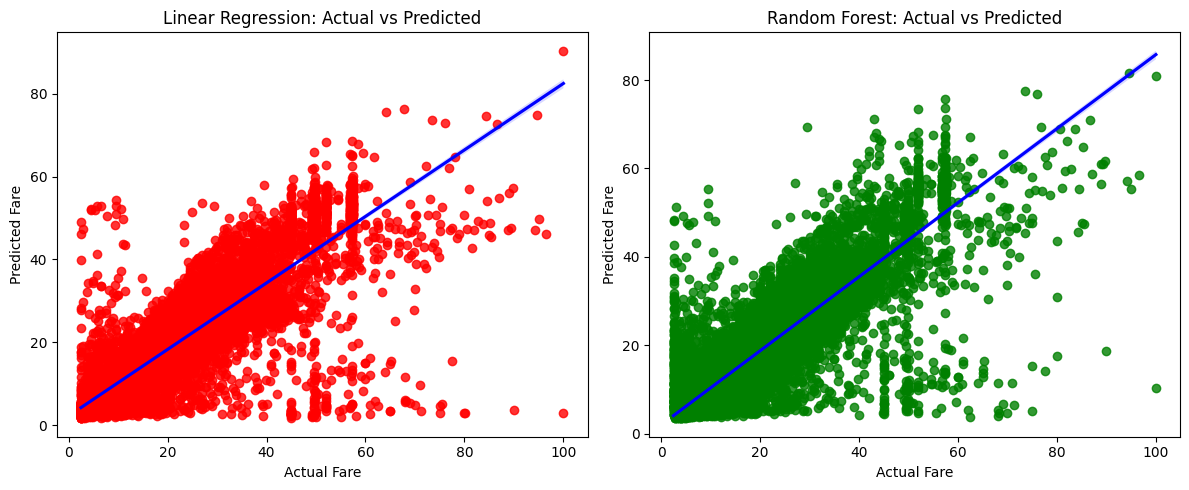

In [10]:
# Visualize regression lines
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.regplot(x=y_test, y=y_pred_lr, color="red", line_kws={"color": "blue"})
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")

plt.subplot(1,2,2)
sns.regplot(x=y_test, y=y_pred_rf, color="green", line_kws={"color": "blue"})
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")

plt.tight_layout()
plt.show()

# 8 - Predict Fare for New Ride

In [11]:
new_ride = pd.DataFrame({
    "distance_km": [5.2],
    "pickup_hr": [14],
    "day": [6],
    "month": [10],
    "year": [2025],
    "passenger_count": [2]
})
new_ride_scaled = scaler.transform(new_ride)
predicted_fare = rf_model.predict(new_ride_scaled)
print(f"Predicted Fare for new ride: ${predicted_fare[0]:.2f}")

Predicted Fare for new ride: $20.07
